In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
import random
pd.options.mode.chained_assignment = None
%matplotlib inline

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import seaborn as sns
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

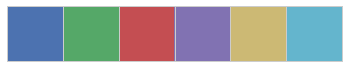

In [230]:
sns.set()
sns.set_style("whitegrid")
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [2]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [231]:
df=pd.read_csv('HyperLeda_a007_full.txt',skiprows=19,skipfooter=5,names=['objname','j2000','modulus','distance','modc','method','ire','bibref','bibcode','calib'])
df.head()

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,objname,j2000,modulus,distance,modc,method,ire,bibref,bibcode,calib
0,PGC000143,J000158.2-152739,24.88 0.09,0.946 0.040,24.88,CMD,51357,Dolphin2000,,None
1,PGC000143,J000158.2-152739,24.84 0.14,0.929 0.062,24.84,Cepheids,51351,Valcheva+2007,,None
2,PGC000143,J000158.2-152739,24.92 0.21,0.964 0.098,24.92,Cepheids,51332,Sakai+2004,,None
3,PGC000143,J000158.2-152739,24.92 0.07,0.966 0.033,24.92,Cepheids,51352,Gieren+2008,,None
4,PGC000143,J000158.2-152739,24.93,0.968,24.93,Cepheids,51353,Sandage+1985,,None


In [232]:
df=pd.read_csv('HyperLeda_a007_full.txt',skiprows=19,skipfooter=5,names=['objname','j2000','modulus','distance','modc','method','ire','bibref','bibcode','calib'])
df['mod']=np.array([i[0:5] for i in np.array(df.modulus,dtype='str')],dtype='float')
df['err']=np.array([i[6:10] for i in np.array(df.modulus,dtype='str')])
df=df.replace('    ',np.nan)
df.err=df.err.astype(float)
df.head()

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,objname,j2000,modulus,distance,modc,method,ire,bibref,bibcode,calib,mod,err
0,PGC000143,J000158.2-152739,24.88 0.09,0.946 0.040,24.88,CMD,51357,Dolphin2000,,None,24.88,0.09
1,PGC000143,J000158.2-152739,24.84 0.14,0.929 0.062,24.84,Cepheids,51351,Valcheva+2007,,None,24.84,0.14
2,PGC000143,J000158.2-152739,24.92 0.21,0.964 0.098,24.92,Cepheids,51332,Sakai+2004,,None,24.92,0.21
3,PGC000143,J000158.2-152739,24.92 0.07,0.966 0.033,24.92,Cepheids,51352,Gieren+2008,,None,24.92,0.07
4,PGC000143,J000158.2-152739,24.93,0.968,24.93,Cepheids,51353,Sandage+1985,,None,24.93,NaN


In [233]:
df.shape # total measurements

(12866, 12)

In [234]:
np.unique(df.method[np.isnan(df.err)])

array(['BBSLF     ', 'BHB       ', 'BRSLF     ', 'BS        ',
       'BS3B      ', 'BS3R      ', 'CMD       ', 'Cepheids  ',
       'DSM       ', 'FP        ', 'GCLF      ', 'HB        ',
       'MS        ', 'PNLF      ', 'RC        ', 'RRLyrae   ',
       'SBF       ', 'SNIa      ', 'TF        ', 'TRGB      ', 'average   '], dtype=object)

In [235]:
np.unique(df.method)

array(['Asteroseis', 'BBSLF     ', 'BHB       ', 'BL        ',
       'BRSLF     ', 'BS        ', 'BS3B      ', 'BS3R      ',
       'BTF       ', 'CMD       ', 'CS        ', 'Cepheids  ',
       'DEB       ', 'DSM       ', 'EPM       ', 'ESM       ',
       'FGLR      ', 'FP        ', 'GCLF      ', 'GCR       ',
       'GW        ', 'HB        ', 'MS        ', 'Maser     ',
       'Miras     ', 'PNLF      ', 'RC        ', 'RRLyrae   ',
       'RSV       ', 'SB-M      ', 'SBF       ', 'SEAM      ',
       'SNIa      ', 'Sersic-M  ', 'Sosie     ', 'TF        ',
       'TRGB      ', 'average   ', 'geometric ', 'spectrosco'], dtype=object)

In [236]:
np.isnan(df.err).sum() # no-error measurements

2473

In [237]:
elist=np.unique(df.objname[np.isnan(df.err)])
len(elist) # galaxies with no-error measurements

1063

In [254]:
dfne=df[np.in1d(df.objname,elist)]
dfne=dfne[np.isfinite(dfne.err)]



In [255]:
for i in np.unique(dfne.method):
    print(i,len(dfne[dfne.method==i]) # do a correctdiscrepancy with FP just for kicks
    # comparison is also not fair due to better precision (and smaller size) in HyperLEDA
    # can also predict per-method TF and FP errors. should do this, actually

BHB        1
BL         1
BS3B       4
CMD        48
CS         1
Cepheids   679
DEB        6
EPM        17
ESM        4
FGLR       9
FP         44
GCLF       4
GCR        2
HB         19
MS         1
Maser      6
Miras      4
PNLF       52
RC         27
RRLyrae    26
RSV        1
SB-M       1
SBF        637
SEAM       3
SNIa       131
Sersic-M   1
Sosie      32
TF         461
TRGB       1211
average    163


In [238]:
df1=df[np.isfinite(df.err)]
namelist=list(df1.objname) # list of galaxies
counter=collections.Counter(namelist) # count measurements per galaxy
ulist=[]
ulist2=[]
nmeas=1
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i] # all galaxies with more than n_meas measurements
    if counter[i]>=1:
        ulist2+=[i] # all galaxies with at least one measurement w/a reported error
print('No. of Galaxies with reported errors is %i' % len(ulist2) )
print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
colu=list(df.columns)
for i in ['objname', 'modc', 'err','j2000']:
    colu.remove(i)
df1.drop(colu, inplace=True, axis=1)
filtr=~np.in1d(elist,ulist2)
nulista=np.asarray(elist)[filtr]
print('No. of Galaxies without reported errors is %i' % len(nulista) )

No. of Galaxies with reported errors is 3999
No. of Galaxies with more than 1 measurements is 2456
No. of Galaxies without reported errors is 225


/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [239]:
%%time
np.random.seed(10)
nbins=10000 # 1e4 -> 4 minutes
em=[] # number of measurements per galaxy
bootp50=[] # mean error from the bootstrap for each galaxy
bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
ecf=[]
eqd=[]
pos=[]
for i in ulist2:
    dfilter=np.in1d(df1['objname'],i)
    dummy=df1[dfilter]
    em+=[len(dummy)] # n_meas, number of measurements per galaxy
    pos+=[dummy.j2000.iloc[0]]
    if len(dummy)>1:
        tli=[]
        for km,ke in zip(dummy['modc'],dummy['err']):
            tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
        tli=np.array(tli)
        booterr=(np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0))/2 # sigma draws from bootstrap for each gal
        bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
    ############## This block should be ran for 10k draws ###############
    #    mymed=np.median(tli,axis=0) #median for error of m error
    #    mst=[np.median(np.abs(tli[:,kk]-mymed[kk])) for kk in range(nbins)]
    #    bootmsig+=[(np.percentile(mst, 84,axis=0)-np.percentile(mst, 16,axis=0))/2e6] # error of m error
    #    bootmother+=[np.median(mst)/1e6]
    #####################################################################
        bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
        bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
        bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
        dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
        wnat,avnat = weighted_std(dummy['modc'],1/dummy['err']**2)
        distwav=10**(avnat/5+1)/1e6
        wsti=0.461*distwav*wnat # weighted standard deviation
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        ecf+=[ecfi]
        eqd+=[np.sqrt(ecfi**2+wsti**2)]  
    if len(dummy)==1:
        bootp50+=[0] # mean error from the bootstrap for each galaxy
        bootsig+=[0] # uncertainty of the error -> may not be a good predictor
        bootmad+=[0] # median absolute deviation (robust)
        wnat,avnat = dummy['err'].iloc[0],dummy['modc'].iloc[0]
        distwav=10**(avnat/5+1)/1e6
        dboot+=[distwav] # regular distance
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        ecf+=[ecfi]
        eqd+=[0]
# weighted std using D and propagated err is similar to propagated D error using weighted std on modulus and error

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/numpy/lib/function_base.py:1142: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


CPU times: user 38.1 s, sys: 443 ms, total: 38.5 s
Wall time: 38.7 s


In [240]:
np.unique(em) #an apt comparison cannot be made with hyperleda, as the max number of TF measurements per galaxy is 5

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42,
       47, 48])

In [248]:
np.percentile(em,99),len(em)*.1

(15.019999999999982, 399.90000000000003)

In [241]:
filt=(np.array(em)<3)&(np.array(em)>1)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]

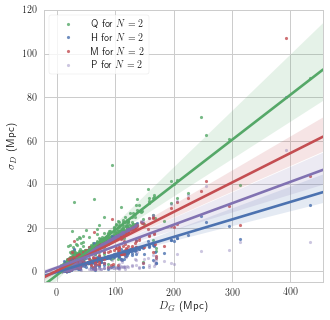

In [243]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N=2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N=2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N=2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N=2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)
plt.savefig('mnras/HLlow.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/HLlow.png', dpi=reso,transparent=True)

(-5, 120)

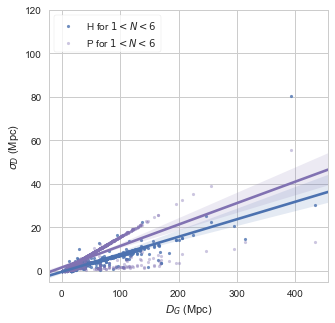

In [186]:
plt.figure(figsize=(5,5))
sns.regplot(x,y,color=current_palette[0],label=r'H for $1<N<6$', scatter_kws={'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $1<N<6$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)

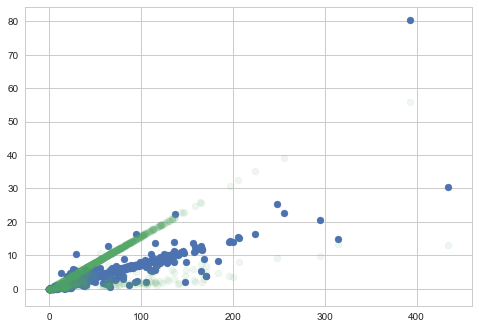

In [187]:
plt.scatter(x,y)
plt.scatter(x,cf,alpha=0.1)

In [244]:
filt=(np.array(em)>2)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]

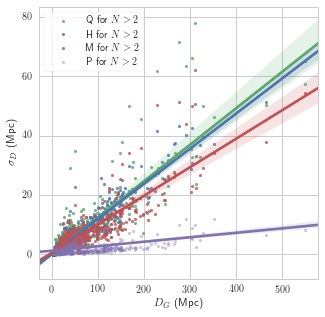

In [245]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
#plt.ylim(0,15)
plt.savefig('mnras/HLhigh.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/HLhigh.png', dpi=reso,transparent=True)

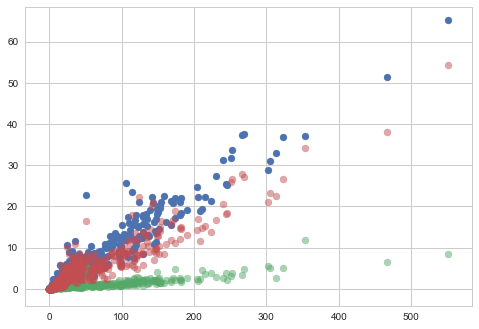

In [196]:
plt.scatter(x,y)
plt.scatter(x,cf,alpha=0.5)
plt.scatter(x,z,alpha=0.5)

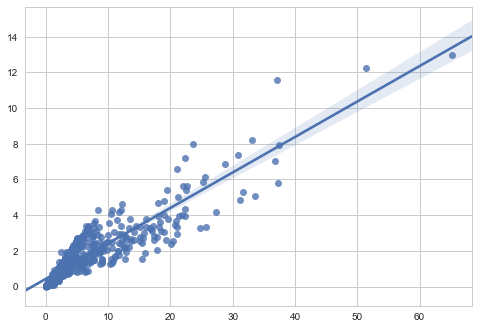

In [199]:
sns.regplot(y,ee)

In [200]:
d = {'objname': ulist2,'j2000':pos, 'meas': em, 'H (Mpc)':bootp50, 'D (Mpc)':dboot,'P (Mpc)':ecf,'Q (Mpc)':eqd,'M (Mpc)':bootmad}
dfb = pd.DataFrame(data=d)
dfb.to_csv("hl_bootstrap_results.csv")

In [271]:
dfb=pd.read_csv('hl_bootstrap_results.csv')

In [250]:
dfe=df[np.in1d(df.objname,nulista)]

In [251]:
for i in np.unique(dfe.method):
    print(i,len(dfe[dfe.method==i])) # do a correctdiscrepancy with FP just for kicks
    # comparison is also not fair due to better precision (and smaller size) in HyperLEDA
    # can also predict per-method TF and FP errors. should do this, actually

BHB        1
BS         30
BS3B       26
BS3R       5
CMD        3
DSM        1
FP         151
GCLF       2
SBF        6
TF         34
TRGB       7
average    15


In [256]:
odf=df[df.method=='TF        ']

In [257]:
df1=odf[np.isfinite(odf.err)]
elist=np.unique(odf.objname[np.isnan(df.err)])
namelist=list(df1.objname) # list of galaxies
counter=collections.Counter(namelist) # count measurements per galaxy
ulist=[]
ulist2=[]
nmeas=1
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i] # all galaxies with more than n_meas measurements
    if counter[i]>=1:
        ulist2+=[i] # all galaxies with at least one measurement w/a reported error
print('No. of Galaxies with reported errors is %i' % len(ulist2) )
print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
colu=list(df.columns)
for i in ['objname', 'modc', 'err','j2000']:
    colu.remove(i)
df1.drop(colu, inplace=True, axis=1)
filtr=~np.in1d(elist,ulist2)
nulista=np.asarray(elist)[filtr]
print('No. of Galaxies without reported errors is %i' % len(nulista) )

No. of Galaxies with reported errors is 2450
No. of Galaxies with more than 1 measurements is 1582
No. of Galaxies without reported errors is 71


/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [258]:
odf=odf[np.in1d(odf.objname,nulista)]

In [259]:
len(nulista)

71

In [260]:
meddist=[]
for i in nulista:
    dummy=odf[odf['objname']==i]
    meddist+=[np.median(10**(dummy.modc/5+1)/1e6)]
meddist=np.array(meddist)

In [261]:
len(meddist)

71

In [262]:
x1=np.array([3.2233139166587161, 140.96666964288357])
filt1=(meddist<x1.max())&(meddist>x1.min())
(filt1).sum() # galaxies in range

70

In [263]:
x2=np.array([2.8327613702075238, 140.96666964288357])
filt2=(meddist<x2.max())&(meddist>x2.min())
(filt2).sum() # galaxies in range

70

In [264]:
samples1=np.loadtxt('posterior_lh.txt')

In [265]:
samples2=np.loadtxt('posterior_lm.txt')

In [266]:
sth1=np.median(samples1,axis=0)
sth2=np.median(samples2,axis=0)

In [267]:
meddist.min()

2.8054336379517104

In [268]:
bfilt=dfb.meas>2
x=dfb['D (Mpc)'][bfilt]
y=dfb.H[bfilt]
z=dfb.M[bfilt]

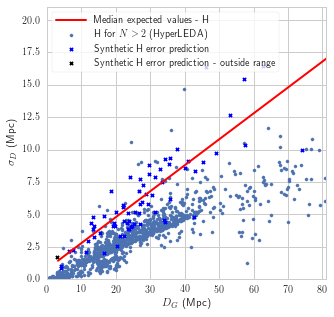

In [269]:
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,y,s=10,label='H for $N>2$ (HyperLEDA)')
xp=np.linspace(x1.min(),x1.max(),2)
modpar=samples1[np.random.randint(len(samples1))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
#plt.scatter(x1,y1,label='H for $N>15$ measurements')
mark='x'
plt.scatter(meddist[filt1],ysim[filt1], c='b',s=10,marker=mark,label='Synthetic H error prediction')
plt.scatter(meddist[~filt1],ysim[~filt1], c='k',s=10,marker=mark,label='Synthetic H error prediction - outside range')
plt.plot(xp,xp*sth1[0]+sth1[1],c='r',linewidth=2,label='Median expected values - H')
plt.xlim(0,81)
plt.ylim(0,21)
plt.legend(frameon=True,loc='upper left')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')
plt.savefig('mnras/predhl1.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/predhl1.png', dpi=reso,transparent=True)

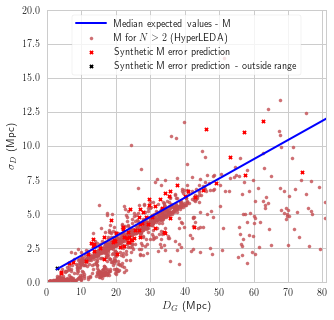

In [270]:
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,z,c=current_palette[2],s=10,label='M for $N>2$ (HyperLEDA)',alpha=0.8)
xp=np.linspace(x2.min(),x2.max(),2)
modpar=samples2[np.random.randint(len(samples2))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
#plt.scatter(x2,y2,c=current_palette[1],label='M for $N>13$ measurements')
mark='x'
plt.scatter(meddist[filt2],ysim[filt2], c='r',s=10,marker=mark,label='Synthetic M error prediction')
plt.scatter(meddist[~filt2],ysim[~filt2], c='k',s=10,marker=mark,label='Synthetic M error prediction - outside range')
plt.plot(xp,xp*sth2[0]+sth2[1],c='b',linewidth=2,label='Median expected values - M')
plt.xlim(0,81)
plt.ylim(0,20)
plt.legend(frameon=True,loc='upper center')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')
plt.savefig('mnras/predhl2.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/predhl2.png', dpi=reso,transparent=True)

In [87]:
fdf=df[df.method=='FP        ']

In [88]:
df1=fdf[np.isfinite(fdf.err)]
elist=np.unique(fdf.objname[np.isnan(df.err)])
namelist=list(df1.objname) # list of galaxies
counter=collections.Counter(namelist) # count measurements per galaxy
ulist=[]
ulist2=[]
nmeas=1
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i] # all galaxies with more than n_meas measurements
    if counter[i]>=1:
        ulist2+=[i] # all galaxies with at least one measurement w/a reported error
print('No. of Galaxies with reported errors is %i' % len(ulist2) )
print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
colu=list(df.columns)
for i in ['objname', 'modc', 'err','j2000']:
    colu.remove(i)
df1.drop(colu, inplace=True, axis=1)
filtr=~np.in1d(elist,ulist2)
nulista=np.asarray(elist)[filtr]
print('No. of Galaxies without reported errors is %i' % len(nulista) )

No. of Galaxies with reported errors is 61
No. of Galaxies with more than 1 measurements is 1
No. of Galaxies without reported errors is 152


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [91]:
len(nulista)

152